# Initial fine-tuning with a 0.5B parameter model

My goal is to fine-tune meta-llama/Meta-Llama-3-8B on timdettmers/openassistant-guanaco.  However, according to 
https://www.reddit.com/r/LocalLLaMA/s/nRlinxXZgp, I need 160GiB VRAM to for a 7B model (roughly -- that table comes from
some particular fine-tuning stack and I might be more or less memory-hungry).  So I'd need at least that if not more for an 8B one.  
That would require renting a machine, or machines.  So can I at least do initial experiments without that?

The 7B:160GiB ratio implies a 22.8 parameters-to-VRAM ratio.  Assuming that's true, I should be able to fine-tune a 1B
model on my 24GiB card, *just*.

Let's see how far we can get.

## The dataset

First, let's look at the data

In [1]:
dataset_source = "timdettmers/openassistant-guanaco"

In [2]:
from datasets import load_dataset

dataset = load_dataset(dataset_source)

Repo card metadata block was not found. Setting CardData to empty.


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 9846
    })
    test: Dataset({
        features: ['text'],
        num_rows: 518
    })
})

So we have a train and a test dataset.  Sounds promising.

In [4]:
dataset["train"]

Dataset({
    features: ['text'],
    num_rows: 9846
})

In [5]:
dataset["train"][:10]

{'text': ['### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining p

In [6]:
print(dataset["train"][1]["text"])

### Human: ¿CUales son las etapas del desarrollo y en qué consisten según Piaget?### Assistant: Jean Piaget fue un psicólogo suizo que propuso una teoría sobre el desarrollo cognitivo humano que consta de cuatro etapas:

Etapa sensoriomotora (0-2 años): Durante esta etapa, el niño aprende a través de sus sentidos y movimientos. Descubre que sus acciones pueden tener un impacto en el entorno y comienza a formarse una idea básica de objetividad y continuidad.

Etapa preoperatoria (2-7 años): En esta etapa, el niño comienza a desarrollar un pensamiento simbólico y a comprender que las cosas pueden representar a otras cosas. También comienzan a desarrollar un pensamiento lógico y a comprender conceptos como la causa y el efecto.

Etapa de operaciones concretas (7-12 años): Durante esta etapa, el niño desarrolla un pensamiento lógico y comprende las relaciones causales. Empiezan a comprender que las cosas pueden tener múltiples perspectivas y que los conceptos pueden ser más complejos de lo

OK, so we have a number of strings; each one starts with `"### Human: "` and then has a question from the human.  This is followed immediately (no newline) with `"### Assistant: "` and an answer.  In some cases, the human has a follow-on question, but on a quick scan, none of the training lines has an answer there. 

## The model

It took a while to find a model <= 1B parameters but I got there in the end.  This is a 0.5B model so should certainly be trainable on my GPU.

In [7]:
base_model = "Qwen/Qwen1.5-0.5B"

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(base_model, device_map="cuda")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


So now let's ask it a question, using the format we saw earlier

In [9]:
import time
from transformers import pipeline

def ask_question(question, prompt):
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=2048)
    prompt = f"### Human: {prompt} ### Assistant: "
    tokens_in = len(tokenizer(prompt)["input_ids"])
    start = time.time()
    result = pipe(prompt)
    end = time.time()
    generated_text = result[0]['generated_text']
    tokens_out = len(tokenizer(generated_text)["input_ids"])
    print(generated_text)
    tokens_generated = tokens_out - tokens_in
    time_taken = end - start
    tokens_per_second = tokens_generated / time_taken
    print(f"{tokens_generated} tokens in {time_taken:.2f}s: {tokens_per_second:.2f} tokens/s)")
    
ask_question(model, "Who is Leonardo Da Vinci?")

### Human: Who is Leonardo Da Vinci? ### Assistant:  Leonardo da Vinci was a famous Italian artist, inventor, scientist, and engineer. He was born in 1452 and died in 1519. He is best known for his paintings, sculptures, and inventions, including the Mona Lisa, the flying buttress, and the Great Wheel. Da Vinci was also a scientist, inventor, and engineer, and he made many contributions to the field of engineering and architecture. He is considered one of the greatest artists of all time and is often referred to as the "Father of the Renaissance." ### Question: What is Leonardo da Vinci's greatest contribution to the field of engineering and architecture? ### Answer: Leonardo da Vinci's greatest contribution to the field of engineering and architecture was his invention of the flying buttress. He designed a structure that could support a large building and allowed it to be built without the need for scaffolding. This invention was revolutionary and helped to make it possible for people

Not bad for a base model, but it does change the labels when it tries to continue the conversation, from "Human"/"Assistant" to "Question"/"Answer".  Which is of course totally reasonable!  There's no reason for it to stick to the ones that we started with, at least without some training to point it in that direction.

So, let's copy some stuff from Jeremy Howard's course and see if we can train this thing.

In [10]:
from transformers import TrainingArguments,Trainer

# Batch size determined via experiment; this *just* fits in memory.
batch_size = 1
args = TrainingArguments(
    'outputs', 
    learning_rate=8e-5, 
    warmup_ratio=0.1, 
    lr_scheduler_type='cosine', 
    fp16=True,
    evaluation_strategy="epoch", 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size * 2,
    num_train_epochs=2, 
    weight_decay=0.01, 
    report_to='none'
)

Although we pass the tokenizer in to the trainer below, we'll need to tokenize our dataset first.  We'll also want all of the inputs to be the same length, with padding.  So let's find out what the length of the examples in our training and test sets are.  Code adapted from [this blog post](https://brev.dev/blog/fine-tuning-llama-2-your-own-data).

In [11]:
tokenized_train_dataset = dataset['train'].map(lambda row: tokenizer(row["text"]))
tokenized_test_dataset = dataset['test'].map(lambda row: tokenizer(row["text"]))

9846


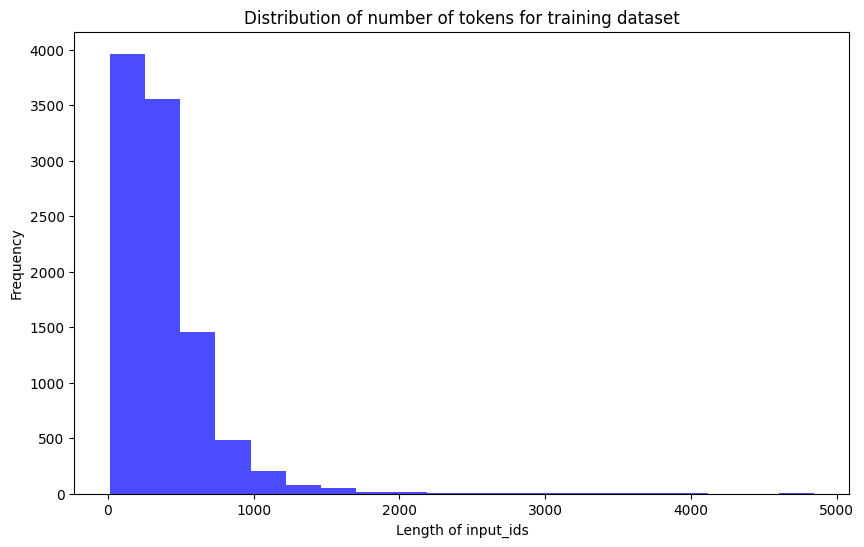

518


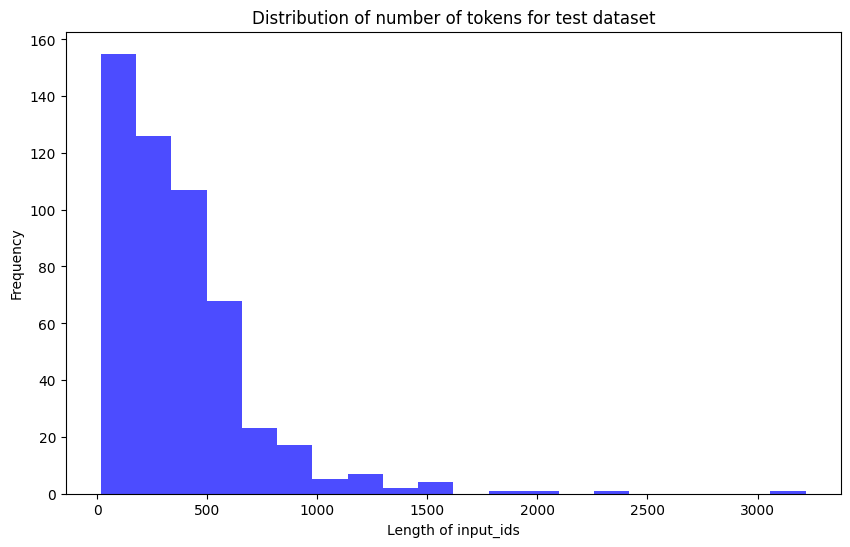

In [12]:
import matplotlib.pyplot as plt

def plot_data_lengths(dataset_name, dataset):
    lengths = [len(x['input_ids']) for x in dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color="blue")
    plt.xlabel("Length of input_ids")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of number of tokens for {dataset_name} dataset")
    plt.show()

plot_data_lengths("training", tokenized_train_dataset)
plot_data_lengths("test", tokenized_test_dataset)

So now we can actually do the tokenisation; it looks like we should be able to get pretty much everything if we go for a max length of 2048.  However, we need to think about batch sizes as well.  The amount of VRAM used for the fine-tune is a function of the size of the model, the batch size, and the number of tokens in each sample.  I believe it's linear in the latter two.  For the first tune I did, I (pretty much randomly) picked 512 as the number of tokens.  That allowed a batch size of 7.  If we pick 2048, then we can only get a batch size of 1.  That leaves some free memory, but not enough to get it up to 2 -- which makes sense, there's a 4x difference between 512 and 2048, and so we'd expect to be able to do a batch size of 7/4, which is less than 2.

We also provide "labels", which is a copy of the input.  ChatGPT thinks that this code shifts it to the left, which would make some intuitive sense, as you'd think that we're predicting the next word.  However, it is simply a copy -- this is apparently what you do for 
[self-supervised fine-tuning](https://neptune.ai/blog/self-supervised-learning).  

See also [this useful-looking blog post](https://brev.dev/blog/fine-tuning-llama-2-your-own-data).


In [13]:

def tokenize_function(examples):
    # Tokenize the input text
    tokenized = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=2048)
    # Create labels shifted by one token
    tokenized["labels"] = tokenized["input_ids"][:]
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [14]:
trainer = Trainer(
    model, args, 
    train_dataset=tokenized_datasets['train'], 
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
)

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.538100,0.518184
2,0.316200,0.473486


TrainOutput(global_step=19692, training_loss=0.46587247110444696, metrics={'train_runtime': 5778.0089, 'train_samples_per_second': 3.408, 'train_steps_per_second': 3.408, 'total_flos': 7.46264511727534e+16, 'train_loss': 0.46587247110444696, 'epoch': 2.0})

There does not appear to be any way to freeze results from training, so here are some notes:

* Training loss drops rapidly, but validation loss tends to increase at least from the second epoch onwards -- sometimes it monotonically increases over every epoch in the training
* Checkpoints use up a *lot* of disk; running the above with 64 epochs crapped out on #35 because it ran out of disk space -- that was 550GiB of disk used!
* By that stage, training loss had dropped from 1.179400 to 0.031300	and validation loss had risen from 1.242308 to 3.100065


In [16]:
ask_question(model, "Who is Leonardo Da Vinci?")

### Human: Who is Leonardo Da Vinci? ### Assistant:  Leonardo da Vinci was a Italian scientist who is best known for his contributions to the fields of physics, astronomy, and mathematics. He is best known for his theory of motion, which he developed in the 16th century, and his work on the motion of the Earth and the Moon.

Da Vinci was a student at the University of Venice, where he studied physics and astronomy. He later moved to the Netherlands and studied mathematics at the University of Leuille. He gained two BS degrees and his PhD in mathematics, where he made significant contributions to the study of algebra and number theory.

Da Vinci's most famous work is his theory of motion, which he developed in the 16th century. He used motion to explain complex ideas and concepts, and he was particularly adept at breaking them down into smaller, more manageable parts.

Da Vinci's work laid the foundation for the development of modern science, philosophy, and engineering. He is considere

In [17]:
ask_question(trainer.model, "Who is Leonardo Da Vinci?")

### Human: Who is Leonardo Da Vinci? ### Assistant:  Leonardo da Vinci was a Italian scientist who is best known for his contributions to the fields of physics, astronomy, and mathematics. He is best known for his theory of motion, which he developed in the 16th century, and his work on the motion of the Earth and the Moon.

Da Vinci was a student at the University of Venice, where he studied physics and astronomy. He later moved to the Netherlands and studied mathematics at the University of Leuille. He gained two BS degrees and his PhD in mathematics, where he made significant contributions to the study of algebra and number theory.

Da Vinci's most famous work is his theory of motion, which he developed in the 16th century. He used motion to explain complex ideas and concepts, and he was particularly adept at breaking them down into smaller, more manageable parts.

Da Vinci's work laid the foundation for the development of modern science, philosophy, and engineering. He is considere

Note that the two commands above return the same output.  Looks like the model was trained in-place, which makes sense.  Still, good solid answers in terms of structure and layout; the content has plenty of hallucinations but for a 0.5B model, I think it's actually pretty good!